In [3]:
"""loop through files in S1_Dataset directory"""
"""create 2D data matrix by appending each new dataset to the bottom of data matrixx"""
"""add a column indicating the paitent ID"""
import os
import pandas as pd
import numpy as np 
S1_PATH = os.path.join('COMP6208-ML-Assignment','Datasets_Healthy_Older_People','S1_Dataset')
S2_PATH = os.path.join('..','..','Datasets_Healthy_Older_People','S2_Dataset')
print('Importing Data...')
s1_data = pd.DataFrame()
patient_id = 0
for filename in os.listdir(S1_PATH):
    if filename != 'README.txt':
        data_path = os.path.join(S1_PATH, filename)
        data = pd.read_csv(data_path, header=None)
        data[9] = np.zeros(data.shape[0])
        data[9] = patient_id
        patient_id = patient_id + 1
        s1_data = s1_data.append(data, ignore_index=True)
s1_data.columns = ['time','frontal','vertical','lateral','antenna_id','rssi','phase','frequency','activity','patient_id']
s1_data = s1_data.drop(columns=['phase','frequency'])
s1_data_by_patient = s1_data.set_index(['patient_id','time'])
print('Done')

Importing Data...
Done


In [0]:
s1_data_by_patient.head()

frontal  vertical   lateral  antenna_id  rssi  activity
patient_id time                                                         
0          0.00  0.27203   1.00820 -0.082102           1 -63.5         1
           0.50  0.27203   1.00820 -0.082102           1 -63.0         1
           1.50  0.44791   0.91636 -0.013684           1 -63.5         1
           1.75  0.44791   0.91636 -0.013684           1 -63.0         1
           2.50  0.34238   0.96229 -0.059296           1 -63.5         1

In [5]:
"""analyse data for sequential learning preprocessing"""

time_intervals = []
too_large_intervals = {}
too_large_interval_limit = 2
prev_time_stamp = 0
index = 0
for time_stamp in s1_data['time']:
    difference = time_stamp - prev_time_stamp
   
    if difference > too_large_interval_limit:
        too_large_intervals[index] = difference
    
    prev_time_stamp = time_stamp 
    if difference > 0:
        time_intervals.append(round(difference,4))
    index = index + 1

"""some large jumps of missing data found"""
print('Maximum time step: ', max(time_intervals)) 
print('Minimum time step: ', min(time_intervals))
print('Number of jumps larger than %ds: ' %too_large_interval_limit, len(too_large_intervals))

"""
for k,v in too_large_intervals.items():
    print('\nIndex: ', k, '\tJump: ', v)
    print(s1_data[k-5:k+5])
"""
    
"""find the smallest timestep"""
from math import gcd

smallest_timestep = time_intervals[0]
for time_step in time_intervals[1:]:
    smallest_timestep = gcd(round(smallest_timestep*1000), round(time_step*1000))/1000

print('Time step to fit everything: ', smallest_timestep)

Maximum time step:  185.15
Minimum time step:  0.02
Number of jumps larger than 2s:  1040
Time step to fit everything:  0.005


In [0]:
"""preprocess data for sequential learning"""
"""filter added to remove large time steps"""
"""filter added to remove """


"""
a data point is a set of vectors with features, which looks like:
<x_n,...,x_n+w>, <y_n,...,y_n+w>, <z_n,...,z_n+w>, <rssi_n,...,rssi_n+w>, <antennaID_n,...,antennaID_n+w>

a label is either the set which contains the features of the n+w+1 item or just the activity:
<x_n+w+1>, <y_n+w+1>, <z_n+w+1>, <rssi_n+w+1>, <antennaID_n+w+1>
or
<activity_n+w+1>
"""
largest_allowed_timestep = 10
window_size = 10
top_level_column_indexes = np.array(range(window_size))
second_level_column_indexes = np.array(['frontal','vertical','lateral','antenna_id','rssi'])
indexes = pd.MultiIndex.from_product([top_level_column_indexes,second_level_column_indexes])

number_of_patients = s1_data_by_patient.index.values[-1][0] + 1
# number_of_patients = 3

all_patients_sequence_data = []
all_patients_sequence_label = []
too_large_count = 0
for patient_index in range(number_of_patients):
    patient_data = s1_data_by_patient.xs(patient_index)
    time_indexes = patient_data.index.values
    
    #start_time = time_indexes[0]
    all_sequence_data = []
    all_sequence_label = []

    for window_start in range(len(time_indexes) - window_size - 1):
        sequence_data = []
        time_stamp = 0
        skip = 0
        for i in range(window_size):
            single_data = patient_data.iloc[window_start+i][:-1].values
            prev_time_stamp = time_stamp
            time_stamp = time_indexes[window_start+i]
            time_difference = time_stamp-prev_time_stamp
            if(time_difference > largest_allowed_timestep):
                skip = 1 
            sequence_data.extend(single_data)

        if(skip == 1):
            too_large_count = too_large_count + 1
            skip = 0
        else:
            all_sequence_data.append(sequence_data)
            all_sequence_label.append( patient_data.iloc[window_start+window_size+1][-1])
    
    all_patients_sequence_data.extend(all_sequence_data)
    all_patients_sequence_label.extend(all_sequence_label)

all_patients_sequence_data = np.asarray(all_patients_sequence_data)
all_patients_sequence_label = np.asarray(all_patients_sequence_label)

print(all_patients_sequence_data.shape)
print(all_patients_sequence_label.shape)
print(too_large_count)

all_patients_sequence_data_pd = pd.DataFrame(all_patients_sequence_data, columns=indexes)
all_patients_sequence_data_pd['label'] = all_patients_sequence_label
all_patients_sequence_data_pd


(1386, 50)
(1386,)
50446


0                                             1           \
       frontal vertical   lateral antenna_id  rssi   frontal vertical   
0     0.272030  1.00820 -0.082102        1.0 -63.5  0.272030  1.00820   
1     0.272030  1.00820 -0.082102        1.0 -63.0  0.447910  0.91636   
2     0.447910  0.91636 -0.013684        1.0 -63.5  0.447910  0.91636   
3     0.447910  0.91636 -0.013684        1.0 -63.0  0.342380  0.96229   
4     0.342380  0.96229 -0.059296        1.0 -63.5  0.342380  0.96229   
5     0.342380  0.96229 -0.059296        4.0 -56.5  0.307210  0.99674   
6     0.307210  0.99674 -0.070699        1.0 -63.5  0.272030  0.99674   
7     0.272030  0.99674 -0.093505        1.0 -64.0  0.236850  1.03120   
8     0.236850  1.03120 -0.127710        1.0 -64.5  0.236850  1.03120   
9     0.236850  1.03120 -0.127710        1.0 -66.0  0.236850  1.03120   
10    0.236850  1.03120 -0.127710        1.0 -63.0  0.236850  1.03120   
11    0.236850  1.03120 -0.127710        1.0 -65.0  0.318930  0.99674   
12    0.318930  0.99674 -0.070699        1.0 -62.0  0.318930  0.99674   
13    0.318930  0.99674 -0.070699        4.0 -56.5  0.471360  0.92784   
14    0.471360  0.92784 -0.002281        1.0 -62.5  0.401010  0.93932   
15    0.401010  0.93932 -0.025087        1.0 -64.0  0.401010  0.93932   
16    0.401010  0.93932 -0.025087        1.0 -62.5  0.401010  0.93932   
17   -0.044557  0.93932  0.111750        1.0 -58.0 -0.044557  0.93932   
18   -0.044557  0.93932  0.111750        1.0 -60.0 -0.044557  0.93932   
19   -0.044557  0.93932  0.111750        3.0 -68.5 -0.044557  0.93932   
20   -0.044557  0.93932  0.111750        4.0 -57.5  0.612070  0.89339   
21    0.612070  0.89339  0.009122        4.0 -57.5  0.612070  0.89339   
22    0.612070  0.89339  0.009122        1.0 -65.0  0.694140  0.83597   
23    0.694140  0.83597  0.054735        4.0 -57.5  0.541710  0.90487   
24    0.541710  0.90487  0.009122        1.0 -67.5  0.588620  0.87042   
25    0.588620  0.87042 -0.036490        4.0 -57.0  0.588620  0.87042   
26    0.588620  0.87042 -0.036490        1.0 -66.5  0.436190  0.96229   
27    0.436190  0.96229 -0.070699        4.0 -57.0  0.436190  0.96229   
28    0.436190  0.96229 -0.070699        4.0 -57.5  0.553440  0.89339   
29    0.553440  0.89339 -0.025087        1.0 -67.0  0.553440  0.89339   
...        ...      ...       ...        ...   ...       ...      ...   
1356  0.612070  0.88191 -0.082102        1.0 -59.5  0.612070  0.88191   
1357  0.612070  0.88191 -0.082102        1.0 -63.0  0.612070  0.88191   
1358  0.612070  0.88191 -0.082102        3.0 -60.0  0.612070  0.88191   
1359  0.612070  0.88191 -0.082102        4.0 -57.0  0.612070  0.88191   
1360  0.612070  0.88191 -0.082102        4.0 -56.5  0.506540  0.90487   
1361  0.189950  1.24940 -0.139120        2.0 -68.0  0.189950  1.24940   
1362  0.189950  1.24940 -0.139120        1.0 -47.5  0.307210  0.97377   
1363  0.307210  0.97377  0.043332        2.0 -57.0  0.307210  0.97377   
1364  0.307210  0.97377  0.043332        2.0 -56.5  0.307210  0.97377   
1365  0.307210  0.97377  0.043332        2.0 -56.0  0.189950  0.97377   
1366  0.189950  0.97377 -0.070699        2.0 -56.0  0.189950  0.97377   
1367  0.189950  0.97377 -0.070699        2.0 -56.0  0.436190  0.95081   
1368  0.436190  0.95081 -0.047893        2.0 -57.5  0.436190  0.95081   
1369  0.436190  0.95081 -0.047893        2.0 -57.0  0.799670  0.81301   
1370  0.799670  0.81301  0.088944        2.0 -56.5  0.799670  0.81301   
1371  0.799670  0.81301  0.088944        2.0 -56.0  0.799670  0.81301   
1372  0.799670  0.81301  0.088944        2.0 -56.0  0.799670  0.81301   
1373  0.248580  1.05420 -0.241740        1.0 -45.5  0.342380  1.18050   
1374  0.342380  1.18050 -0.116310        1.0 -45.0  0.060972  1.07710   
1375  0.060972  1.07710 -0.036490        1.0 -44.5  0.131320  1.05420   
1376  0.131320  1.05420 -0.082102        1.0 -49.5  0.471360  0.90487   
1377  0.471360  0.90487  0.020525        2.0 -56.0  0.471360  0.90487  

In [0]:
"""preprocess data for sequential learning"""
"""Keras requries 3D array for the LSTM Input"""
window_size = 10
top_level_column_indexes = np.array(range(window_size))
second_level_column_indexes = np.array(['frontal','vertical','lateral','antenna_id','rssi'])
indexes = pd.MultiIndex.from_product([top_level_column_indexes,second_level_column_indexes])

number_of_patients = s1_data_by_patient.index.values[-1][0] + 1
# number_of_patients = 3

too_large_count = 0
all_patients_sequence_data = []
all_patients_sequence_label = []
for patient_index in range(number_of_patients):
    patient_data = s1_data_by_patient.xs(patient_index)
    time_indexes = patient_data.index.values
    
    #start_time = time_indexes[0]
    all_sequence_data = []
    all_sequence_label = []

    for window_start in range(len(time_indexes) - window_size - 1):
        sequence_data = []
        time_stamp = 0
        skip = 0
        for i in range(window_size):
            single_data = patient_data.iloc[window_start+i][:-1].values
            prev_time_stamp = time_stamp
            time_stamp = time_indexes[window_start+i]
            time_difference = time_stamp-prev_time_stamp
            if(time_difference > largest_allowed_timestep):
                skip = 1 
            sequence_data.append(single_data)
        
        if(skip == 1):
            too_large_count = too_large_count + 1
        else:
            all_sequence_data.append(sequence_data)
            all_sequence_label.append( patient_data.iloc[window_start+window_size+1][-1])
    
    all_patients_sequence_data.extend(all_sequence_data)
    all_patients_sequence_label.extend(all_sequence_label)

all_patients_sequence_data = np.asarray(all_patients_sequence_data)
all_patients_sequence_label = np.asarray(all_patients_sequence_label)
print(too_large_count)


50446
[[[ 2.7203e-01  1.0082e+00 -8.2102e-02  1.0000e+00 -6.3500e+01]
  [ 2.7203e-01  1.0082e+00 -8.2102e-02  1.0000e+00 -6.3000e+01]
  [ 4.4791e-01  9.1636e-01 -1.3684e-02  1.0000e+00 -6.3500e+01]
  ...
  [ 2.7203e-01  9.9674e-01 -9.3505e-02  1.0000e+00 -6.4000e+01]
  [ 2.3685e-01  1.0312e+00 -1.2771e-01  1.0000e+00 -6.4500e+01]
  [ 2.3685e-01  1.0312e+00 -1.2771e-01  1.0000e+00 -6.6000e+01]]

 [[ 2.7203e-01  1.0082e+00 -8.2102e-02  1.0000e+00 -6.3000e+01]
  [ 4.4791e-01  9.1636e-01 -1.3684e-02  1.0000e+00 -6.3500e+01]
  [ 4.4791e-01  9.1636e-01 -1.3684e-02  1.0000e+00 -6.3000e+01]
  ...
  [ 2.3685e-01  1.0312e+00 -1.2771e-01  1.0000e+00 -6.4500e+01]
  [ 2.3685e-01  1.0312e+00 -1.2771e-01  1.0000e+00 -6.6000e+01]
  [ 2.3685e-01  1.0312e+00 -1.2771e-01  1.0000e+00 -6.3000e+01]]

 [[ 4.4791e-01  9.1636e-01 -1.3684e-02  1.0000e+00 -6.3500e+01]
  [ 4.4791e-01  9.1636e-01 -1.3684e-02  1.0000e+00 -6.3000e+01]
  [ 3.4238e-01  9.6229e-01 -5.9296e-02  1.0000e+00 -6.3500e+01]
  ...
  [ 2.3685e-

In [0]:
"""Randomize and Split the data into Train, Validation and Test"""
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

data, label = unison_shuffled_copies(all_patients_sequence_data,all_patients_sequence_label)


train_data = data[:1100]
val_data =  data[1100:1200]
test_data =  data[1200:]

train_label = label[:1100]
val_label =  label[1100:1200]
test_label =  label[1200:]

print(train_data.shape)
print(train_label.shape)



(1100, 10, 5)
(1100,)


In [0]:
"""setup and train the decision tree model"""
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.utils import to_categorical
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(500,return_sequences=True, input_shape=(10, 5)))
model.add(LSTM(500, return_sequences=True))
model.add(LSTM(500))
model.add(Dense(5, activation='softmax'))

model.summary()

adam = Adam(lr=0.001)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_label_binary = to_categorical(train_label)
val_label_binary = to_categorical(val_label)

model.fit(train_data, train_label_binary, 
          epochs=40, batch_size=10,
          validation_data=(val_data,val_label_binary))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 10, 500)           1012000   
_________________________________________________________________
lstm_28 (LSTM)               (None, 10, 500)           2002000   
_________________________________________________________________
lstm_29 (LSTM)               (None, 500)               2002000   
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 2505      
Total params: 5,018,505
Trainable params: 5,018,505
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 100 samples
Epoch 1/40
1100/1100 [==============================] - 31s 28ms/step - loss: 0.8865 - acc: 0.6600 - val_loss: 0.4335 - val_acc: 0.8700
Epoch 2/40
1100/1100 [==============================] - 27s 25ms/step - loss: 0.4

In [0]:
"""Evaluate Model"""
from sklearn.metrics import confusion_matrix

train_pred = np.argmax(model.predict(train_data),axis=1)
conf_matrix = confusion_matrix(train_label, train_pred)
print('Train Set:')
print(conf_matrix)
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = conf_matrix[index,index]/sum(conf_matrix[:,index])
    recall = conf_matrix[index,index]/sum(conf_matrix[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

test_pred = np.argmax(model.predict(test_data),axis=1)
conf_matrix = confusion_matrix(test_label, test_pred)
print('\nTest Set:')
print(conf_matrix)
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = conf_matrix[index,index]/sum(conf_matrix[:,index])
    recall = conf_matrix[index,index]/sum(conf_matrix[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

Train Set:
[[562   0   0   0]
 [  0 161   0   0]
 [  0   0 317   0]
 [  0   7   0  53]]
sit on bed precision: 1.0
sit on bed recall: 1.0
sit on chair precision: 0.9583333333333334
sit on chair recall: 1.0
lying precision: 1.0
lying recall: 1.0
ambulating precision: 1.0
ambulating recall: 0.8833333333333333

Test Set:
[[99  0  0  0]
 [ 0 35  0  0]
 [ 0  0 43  0]
 [ 0  0  0  9]]
sit on bed precision: 1.0
sit on bed recall: 1.0
sit on chair precision: 1.0
sit on chair recall: 1.0
lying precision: 1.0
lying recall: 1.0
ambulating precision: 1.0
ambulating recall: 1.0


In [0]:
"""Evaluate Model"""
from sklearn.metrics import confusion_matrix

train_pred = np.argmax(model.predict(train_data),axis=1)
conf_matrix = confusion_matrix(train_label, train_pred)
print('Train Set:')
print(conf_matrix)
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = conf_matrix[index,index]/sum(conf_matrix[:,index])
    recall = conf_matrix[index,index]/sum(conf_matrix[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

test_pred = np.argmax(model.predict(test_data),axis=1)
conf_matrix = confusion_matrix(test_label, test_pred)
print('\nTest Set:')
print(conf_matrix)
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = conf_matrix[index,index]/sum(conf_matrix[:,index])
    recall = conf_matrix[index,index]/sum(conf_matrix[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

Train Set:
[[562   0   0   0]
 [  0 161   0   0]
 [  0   0 317   0]
 [  0   7   0  53]]
sit on bed precision: 1.0
sit on bed recall: 1.0
sit on chair precision: 0.9583333333333334
sit on chair recall: 1.0
lying precision: 1.0
lying recall: 1.0
ambulating precision: 1.0
ambulating recall: 0.8833333333333333

Test Set:
[[99  0  0  0]
 [ 0 35  0  0]
 [ 0  0 43  0]
 [ 0  0  0  9]]
sit on bed precision: 1.0
sit on bed recall: 1.0
sit on chair precision: 1.0
sit on chair recall: 1.0
lying precision: 1.0
lying recall: 1.0
ambulating precision: 1.0
ambulating recall: 1.0


In [0]:
"""Save Final Model"""
from keras.models import load_model
model.save('lstm_model.h5')

In [0]:
"""Load Previously Trained Model"""

model2 = load_model('lstm_model.h5')

train_pred = np.argmax(model2.predict(train_data),axis=1)
conf_matrix = confusion_matrix(train_label, train_pred)
print('Train Set:')
print(conf_matrix)
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = conf_matrix[index,index]/sum(conf_matrix[:,index])
    recall = conf_matrix[index,index]/sum(conf_matrix[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

test_pred = np.argmax(model.predict(test_data),axis=1)
conf_matrix = confusion_matrix(test_label, test_pred)
print('\nTest Set:')
print(conf_matrix)
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = conf_matrix[index,index]/sum(conf_matrix[:,index])
    recall = conf_matrix[index,index]/sum(conf_matrix[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

Train Set:
[[562   0   0   0]
 [  0 161   0   0]
 [  0   0 317   0]
 [  0   7   0  53]]
sit on bed precision: 1.0
sit on bed recall: 1.0
sit on chair precision: 0.9583333333333334
sit on chair recall: 1.0
lying precision: 1.0
lying recall: 1.0
ambulating precision: 1.0
ambulating recall: 0.8833333333333333

Test Set:
[[99  0  0  0]
 [ 0 35  0  0]
 [ 0  0 43  0]
 [ 0  0  0  9]]
sit on bed precision: 1.0
sit on bed recall: 1.0
sit on chair precision: 1.0
sit on chair recall: 1.0
lying precision: 1.0
lying recall: 1.0
ambulating precision: 1.0
ambulating recall: 1.0


In [4]:
!git clone https://github.com/scbw1g15/COMP6208-ML-Assignment.git

Cloning into 'COMP6208-ML-Assignment'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 341 (delta 13), reused 24 (delta 10), pack-reused 314
Receiving objects: 100% (341/341), 60.00 MiB | 29.49 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [1]:
!git clone https://github.com/scbw1g15/COMP6208-ML-Assignment.git

Cloning into 'COMP6208-ML-Assignment'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 341 (delta 13), reused 24 (delta 10), pack-reused 314
Receiving objects: 100% (341/341), 60.00 MiB | 36.92 MiB/s, done.
Resolving deltas: 100% (126/126), done.


Number of Remaining Patients:  29


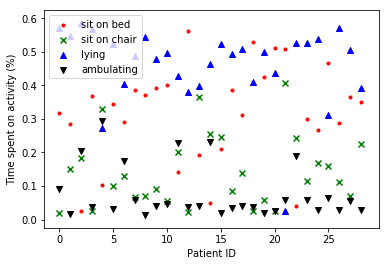

Done


In [6]:
import activity_analysis as aa
#two new features added, euler angles Pitch and roll
#new columns ['time','frontal','vertical','lateral','id','rssi','phase','frequency','roll','pitch','activity']
#            ['0',    '1',      '2',        '3' ,    '4',  '5',   '6',     '7',       '8',    '9',    '10']
tool = aa.Tool()
import pandas as pd
filtered_patients,filtered_activity = tool.filter_unbalances(60)#enter percentege
tool.patient_activity = filtered_activity
tool.patient_list = filtered_patients#filtering based on activity
tool.plot()

In [46]:
#interpolate_timeseries(window, steps, kind='linear', filtering = False, filter_features = [],ts_features = [1,2,3,4,5,6,7,8,9]))
#window given in seconds e.g. 5s
#steps also given in seconds e.g. 0.1
#kind (optional): type of interpolation e.g. ‘linear’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’,
#‘previous’, ‘next’, where ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ for more info see scipy.interp1d
#filtering & filter_features (optional): applies an lpf on the chosen features given by their indexes e.g. when filtering = True
#filter_features[1,2,3] will apply an lpf on the 3 axis of accelerometer
#ts_features (optional): will only transform these features to a time series e.g. [1,2,3,4,5,6,7,8,9] all features are transformed
time_series_patients, patients_labels= tool.interpolate_timeseries(10,0.2,ts_features=[1,2,3,4,5,8,9])
# time_series_patients = pd.DataFrame(time_series_patients[0])
time_series_patients[0]


0.0                                                             \
       frontal  vertical   lateral   id       rssi        roll      pitch   
0     0.166500  1.031200 -0.059296  1.0 -44.500000   93.297866  -9.157760   
1     0.229033  0.985260 -0.097305  1.0 -43.833333   95.698574 -13.074594   
2     0.260300  0.962290 -0.116310  1.0 -43.500000   96.898928 -15.033011   
3     0.283760  0.996740 -0.082102  1.0 -43.000000   94.715829 -15.841247   
4     0.330660  0.996740 -0.070699  1.0 -55.750000   94.063610 -18.277850   
5     0.377560  0.996740 -0.059296  3.0 -68.500000   93.411390 -20.714452   
6     0.377560  0.996740 -0.059296  1.0 -45.000000   93.411390 -20.714452   
7     0.014071  1.065600 -0.104910  1.0 -48.500000   95.629784  -0.752949   
8     0.039543  1.057289 -0.102551  1.0 -49.327586   95.540887  -2.201053   
9     0.107468  1.035126 -0.096259  1.0 -51.534483   95.303829  -6.062662   
10    0.175393  1.012963 -0.089967  1.0 -53.741379   95.066771  -9.924272   
11    0.243319  0.990801 -0.083675  1.0 -55.948276   94.829713 -13.785881   
12    0.260300  0.985260 -0.082102  2.0 -56.500000   94.770449 -14.751283   
13    0.249878  0.991893 -0.082609  2.0 -56.255556   94.768145 -14.153371   
14    0.229033  1.005159 -0.083622  2.0 -55.766667   94.763538 -12.957545   
15    0.208188  1.018424 -0.084636  2.0 -55.277778   94.758931 -11.761720   
16    0.187343  1.031690 -0.085650  2.0 -54.788889   94.754324 -10.565895   
17    0.166498  1.044956 -0.086663  2.0 -54.300000   94.749718  -9.370070   
18    0.145654  1.058222 -0.087677  2.0 -53.811111   94.745111  -8.174244   
19    0.124809  1.071488 -0.088690  2.0 -53.322222   94.740504  -6.978419   
20    0.103964  1.084753 -0.089704  2.0 -52.833333   94.735897  -5.782594   
21    0.083119  1.098019 -0.090718  2.0 -52.344444   94.731290  -4.586769   
22    0.062274  1.111285 -0.091731  2.0 -51.855556   94.726683  -3.390943   
23    0.041430  1.124551 -0.092745  2.0 -51.366667   94.722076  -2.195118   
24    0.025796  1.134500 -0.093505  2.0 -51.000000   94.718621  -1.298249   
25    0.025796  1.134500 -0.093505  2.0 -51.000000   94.718621  -1.298249   
26    0.025796  1.134500 -0.093505  2.0 -50.500000   94.718621  -1.298249   
27    0.042505  1.122445 -0.088374  2.0 -50.800000   94.475912  -2.274647   
28    0.064783  1.106372 -0.081532  2.0 -51.200000   94.152301  -3.576512   
29    0.087062  1.090299 -0.074690  2.0 -51.600000   93.828690  -4.878376   
...        ...       ...       ...  ...        ...         ...        ...   
1299  1.102220  0.128612 -0.148240  4.0 -66.200000  139.011309 -79.898533   
1300  1.116300  0.124020 -0.139120  4.0 -67.000000  138.294440 -80.527421   
1301  1.116300  0.124020 -0.139120  4.0 -67.000000  138.294440 -80.527421   
1302  1.179600  0.096460 -0.104909  4.0 -65.800000  137.185487 -83.035754   
1303  1.221800  0.078086 -0.082102  4.0 -65.000000  136.446185 -84.707976   
1304  1.214760  0.080382 -0.084383  4.0 -64.100000  136.409938 -84.516781   
1305  1.186600  0.089568 -0.093506  4.0 -60.500000  136.264946 -83.752001   
1306  1.158440  0.098754 -0.102629  4.0 -56.900000  136.119955 -82.987221   
1307  1.151400  0.101050 -0.104910  3.0 -56.000000  136.083707 -82.796026   
1308  1.135800  0.106157 -0.115043  3.0 -60.000000  137.212378 -82.147100   
1309  1.116300  0.112540 -0.127710  4.0 -65.000000  138.623216 -81.335943   
1310  1.116300  0.112540 -0.127710  4.0 -65.000000  138.623216 -81.335943   
1311  1.097540  0.130912 -0.129992  4.0 -63.200000  135.748449 -80.351113   
1312  1.078780  0.149284 -0.132274  4.0 -61.400000  132.873682 -79.366282   
1313  1.060020  0.167656 -0.134556  4.0 -59.600000  129.998915 -78.381452   
1314  1.041260  0.186028 -0.136838  4.0 -57.800000  127.124149 -77.396621   
1315  1.022500  0.204400 -0.139120  1.0 -56.000000  124.249382 -76.411791   
1316  1.022500  0.204400 -0.139120  1.0 -56.000000  124.249382 -76.411791   
1317  1.022500  0.204400 -0.139120  3.0 -54.000000  124.249382 -76.411791   
1318  1

In [0]:
# sum = 0
# for i in patients_labels:
#     sum = sum+len(i)
# print(sum)

# sum=0


# for i in time_series_patients:
#     sum = sum+len(i)
# print(sum)

In [47]:
    """Randomize and Split the data into Train, Validation and Test"""
import numpy as np
#lookahead*time steps = seconds -> ts = 0.2 lookahead = 5, predict what happens in 1s
lookahead = 5 
#turn 1D
patients_labels = [pd.DataFrame(l) for l in patients_labels]
features = pd.concat(list(time_series_patients))
features = features[:-lookahead]
features = pd.DataFrame(features, columns=time_series_patients[0].columns)

#fuk pandas
features_array = []
group = []
t_prev = 0
for t,f in features:
        if t_prev != t:
            features_array.append(group)
            group = []
        group.append(list(features[t,f]))
        t_prev= t

labels = pd.concat(list(patients_labels))
labels = labels[lookahead::]

print(len(features))
print(len(labels))


all_patients_sequence_data_2= np.array(features_array)
all_patients_sequence_data_2 = np.transpose(all_patients_sequence_data_2, (2, 1, 0))
all_patients_sequence_label_2= np.asarray(labels)

print("Features Shape:", all_patients_sequence_data_2.shape)
print("Label Shape:", all_patients_sequence_label_2.shape)

def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

data, label = unison_shuffled_copies(all_patients_sequence_data_2,all_patients_sequence_label_2)

percentage = [0.7,0.1,0.2]
indexes = []
sum = 0
for a in percentage:
        sum = sum+a*len(data)
        indexes.append(round(sum))
        
train_data = data[:indexes[0]]
val_data =  data[indexes[0]:indexes[1]]
test_data =  data[indexes[1]:]

train_label = label[:indexes[0]]
val_label =  label[indexes[0]:indexes[1]]
test_label =  label[indexes[1]:]

x,y,z = train_data.shape
print(train_data.shape)
print(train_label.shape)
print(y,z)


55624
55624
Features Shape: (55624, 7, 49)
Label Shape: (55624, 1)
(38937, 7, 49)
(38937, 1)
7 49


In [50]:
#@title Default title text
"""setup and train the decision tree model"""
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
model = Sequential()
model.add(LSTM(500,return_sequences=True, input_shape=(y,z)))
model.add(LSTM(500, return_sequences=True))
model.add(LSTM(500))
model.add(Dense(5, activation='softmax'))

#5 epoch patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.summary()

adam = Adam(lr=0.001)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_label_binary = to_categorical(train_label)
val_label_binary = to_categorical(val_label)

model.fit(train_data, train_label_binary, 
          epochs=40, batch_size=10,
          validation_data=(val_data,val_label_binary), callbacks= [es])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 7, 500)            1100000   
_________________________________________________________________
lstm_20 (LSTM)               (None, 7, 500)            2002000   
_________________________________________________________________
lstm_21 (LSTM)               (None, 500)               2002000   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2505      
Total params: 5,106,505
Trainable params: 5,106,505
Non-trainable params: 0
_________________________________________________________________
Train on 38937 samples, validate on 5562 samples
Epoch 1/40
38937/38937 [==============================] - 186s 5ms/step - loss: 0.4351 - acc: 0.8363 - val_loss: 0.3000 - val_acc: 0.9006
Epoch 2/40
38937/38937 [==============================] - 178s 5ms/step - los

In [0]:
def sum(list):
  res = 0 
  for i in list:
    res+=i
  return res

In [52]:

"""Evaluate Model"""
from sklearn.metrics import confusion_matrix

train_pred = np.argmax(model.predict(train_data),axis=1)
conf_matrix = confusion_matrix(train_label, train_pred)
print('Train Set:')
print(conf_matrix)
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = conf_matrix[index,index]/sum(conf_matrix[:,index])
    recall = conf_matrix[index,index]/sum(conf_matrix[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

test_pred = np.argmax(model.predict(test_data),axis=1)
conf_matrix = confusion_matrix(test_label, test_pred)
print('\nTest Set:')
print(conf_matrix)
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = conf_matrix[index,index]/sum(conf_matrix[:,index])
    recall = conf_matrix[index,index]/sum(conf_matrix[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

Train Set:
[[12294    33    49   130]
 [    3 10377     1    15]
 [   29     2 13609     9]
 [   30    76    29  2251]]
sit on bed precision: 0.9949821948850761
sit on bed recall: 0.9830481368942907
sit on chair precision: 0.98941647597254
sit on chair recall: 0.9981723739899961
lying precision: 0.994228521332554
lying recall: 0.997069382372335
ambulating precision: 0.935966735966736
ambulating recall: 0.9434199497066219

Test Set:
[[3523   23   27   49]
 [   0 2895    0    9]
 [  22    1 3917    9]
 [  26   20    5  599]]
sit on bed precision: 0.9865583870064407
sit on bed recall: 0.9726670347874102
sit on chair precision: 0.9850289214018374
sit on chair recall: 0.996900826446281
lying precision: 0.9918966827044822
lying recall: 0.9918966827044822
ambulating precision: 0.8993993993993994
ambulating recall: 0.9215384615384615


In [0]:
"""Save Final Model"""
from keras.models import load_model
model.save('lstm_model_process_1slookahead.h5')

In [54]:
"""Load Previously Trained Model"""

model2 = load_model('lstm_model_process_1slookahead.h5')

train_pred = np.argmax(model2.predict(train_data),axis=1)
conf_matrix = confusion_matrix(train_label, train_pred)
print('Train Set:')
print(conf_matrix)
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = conf_matrix[index,index]/sum(conf_matrix[:,index])
    recall = conf_matrix[index,index]/sum(conf_matrix[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

test_pred = np.argmax(model.predict(test_data),axis=1)
conf_matrix = confusion_matrix(test_label, test_pred)
print('\nTest Set:')
print(conf_matrix)
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = conf_matrix[index,index]/sum(conf_matrix[:,index])
    recall = conf_matrix[index,index]/sum(conf_matrix[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

Train Set:
[[12294    33    49   130]
 [    3 10377     1    15]
 [   29     2 13609     9]
 [   30    76    29  2251]]
sit on bed precision: 0.9949821948850761
sit on bed recall: 0.9830481368942907
sit on chair precision: 0.98941647597254
sit on chair recall: 0.9981723739899961
lying precision: 0.994228521332554
lying recall: 0.997069382372335
ambulating precision: 0.935966735966736
ambulating recall: 0.9434199497066219

Test Set:
[[3523   23   27   49]
 [   0 2895    0    9]
 [  22    1 3917    9]
 [  26   20    5  599]]
sit on bed precision: 0.9865583870064407
sit on bed recall: 0.9726670347874102
sit on chair precision: 0.9850289214018374
sit on chair recall: 0.996900826446281
lying precision: 0.9918966827044822
lying recall: 0.9918966827044822
ambulating precision: 0.8993993993993994
ambulating recall: 0.9215384615384615
